In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Part 1

#### Load the MNIST Dataset

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
X=X.to_numpy()
y = y.astype(np.uint8)

#### Displaying one item from the dataset:

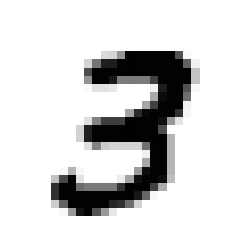

In [9]:
random_digit = X[7]
random_digits_img = random_digit.reshape(28, 28)
plt.figure(figsize=(3, 3))
plt.imshow(random_digits_img, cmap="binary")
plt.axis("off")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

train_indices = (y_train.astype(int) == 5) | (y_train.astype(int) == 3)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = (y_test.astype(int) == 5) | (y_test.astype(int) == 3)
X_test = X_test[test_indices]
y_test = y_test[test_indices]


#### Training the binary classifier

In [11]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([X[0]])

array([False])

#### Performance Measures

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.92962867, 0.95299922, 0.94701299])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

#### Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_train_3, y_train_pred)
c_matrix

array([[4994,  427],
       [ 229, 5902]])

#### Precision & Recall

In [17]:
precision = c_matrix[1][1] / (c_matrix[0][1] + c_matrix[1][1])
precision

0.9325327855901406

In [18]:
recall = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[1][0])
recall

0.9626488337954656

#### f1 - score

In [19]:
f1_score = 2/(1/recall + 1/precision)
f1_score

0.9473515248796146

#### Generating prediction scores and plotting Precision vs Threshold & Recall vs Threshold

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")

In [21]:
y_scores

array([ -61525.29744923,  416563.09004226,  469716.27101228, ...,
        -93302.86678404,  214978.24566611, -184722.86899507])

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

In [23]:
def plot_func(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel("Threshold")

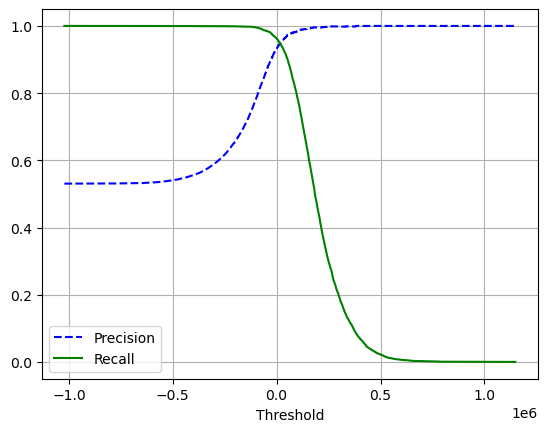

In [24]:
plot_func(precisions, recalls, thresholds)
plt.show()

#### Plotting the ROC Curve and evaluating ROC AUC score

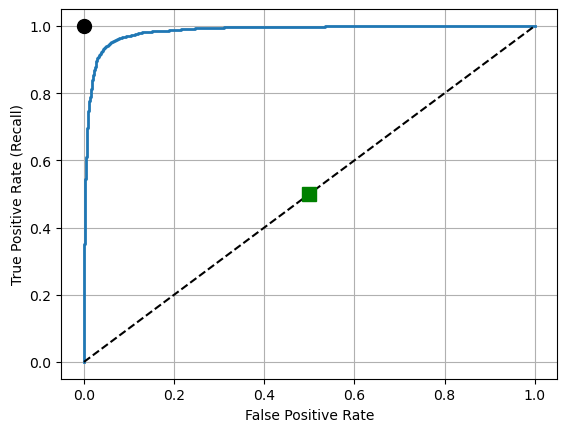

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')# dashed diagonal
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.plot(0, 1, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")
    plt.plot(0.5, 0.5, marker="s", markersize=10, markeredgecolor="green", markerfacecolor="green")

    
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_3, y_scores)

0.9851212013087797

#### Using the Random forest classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3, method="predict_proba")

In [28]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)

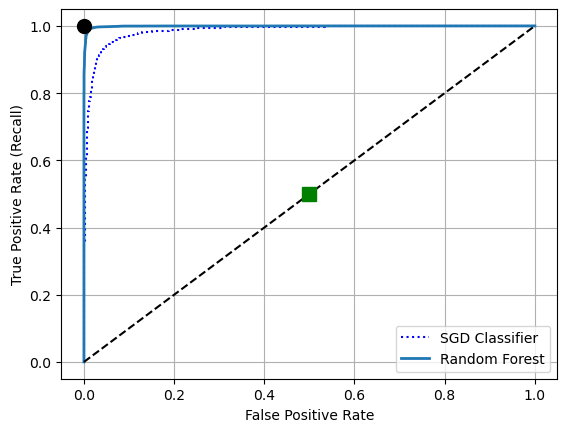

In [29]:
plt.plot(fpr, tpr, "b:", label="SGD Classifier")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
roc_auc_score(y_train_3, y_scores_forest)

0.9992079106873717

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.94884446, 0.94962347, 0.94649351])

In [32]:
y_probas_forest = cross_val_predict(forest_clf, X_train_scaled, y_train_3, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)

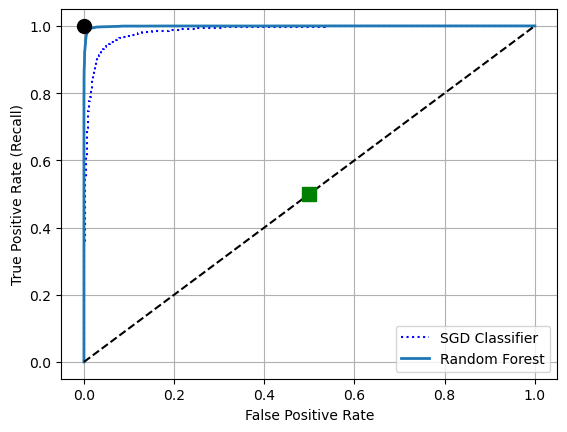

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD Classifier")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### Part - 2

In [34]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### Binary classifier for 3 vs 5

In [35]:
train_indices = (y_train.astype(int) == 5) | (y_train.astype(int) == 3)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = (y_test.astype(int) == 5) | (y_test.astype(int) == 3)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [36]:
sgd_clf_3v5 = SGDClassifier(random_state=42)
sgd_clf_3v5.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

#### Binary Classifier for 3 vs others

In [37]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [38]:
some_digit = X[7]
sgd_clf_3vOthers = SGDClassifier(random_state=42)
sgd_clf_3vOthers.fit(X_train, y_train_3)

SGDClassifier(random_state=42)

In [39]:
sgd_clf_3vOthers.predict([some_digit])

array([False])

#### Binary Classifier for 5 vs Others

In [40]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf_5vOthers = SGDClassifier(random_state=42)
sgd_clf_5vOthers.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [41]:
sgd_clf_5vOthers.predict([some_digit])

array([False])

#### Building a Multiclass classifier form the binary classifiers

In [42]:
import random
def multiclass_classifier(img):
    wins = {"3":0, "5":0, "Others":0}
    assume3, assume5, assumeOther = 0, 0, 0;
    
    if not sgd_clf_3v5.predict([img])[0]: # assuming 3
        wins["3"] += 1
    if sgd_clf_3vOthers.predict([img])[0]:
        wins["3"] += 1
    
    if sgd_clf_3v5.predict([img])[0]:  # assuming 5
        wins["5"] += 1
    if sgd_clf_5vOthers.predict([img])[0]:
        wins["5"] += 1
        
    if not sgd_clf_3vOthers.predict([img])[0]: # assuming other digit
        wins["Others"] += 1
    if not sgd_clf_5vOthers.predict([img])[0]:
        wins["Others"] += 1
        
    max_wins = max(wins.values())
    max_classes = [cls for cls, win in wins.items() if win == max_wins]
    if len(max_classes) == 1:
        return max_classes[0]
    else:
        random.seed() 
        return random.choice(max_classes)



In [43]:
multiclass_classifier(X[0])

'5'

### Part - 3

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X[:60000], y[:60000])

KNeighborsClassifier()

In [46]:
knn_clf.predict([X[0]])

array([5], dtype=uint8)

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(y[60000:], knn_clf.predict(X[60000:]))

0.9688

#### Building classifier that gives accuracy above 97%

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid=[{'weights': ["uniform", "distance"], "n_neighbors": [3, 4, 5]}]
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X[:60000], y[:60000])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  22.9s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  21.9s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  21.9s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  21.9s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  21.6s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  21.4s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  21.7s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  22.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  21.2s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  21.4s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  25.7s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [49]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [50]:
grid_search.best_score_

0.9716166666666666

In [51]:
y_train_pred_knn = cross_val_predict(knn_clf, X[:60000], y[:60000], cv=3)

In [52]:
conf_mx = confusion_matrix(y[:60000], y_train_pred_knn)
conf_mx

array([[5882,    4,    5,    0,    1,    5,   19,    1,    2,    4],
       [   2, 6705,   10,    2,    1,    1,    3,   11,    2,    5],
       [  51,   60, 5695,   15,   11,    4,    9,   87,   17,    9],
       [   8,   16,   39, 5903,    1,   63,    4,   40,   33,   24],
       [   3,   53,    1,    1, 5628,    0,   13,   11,    2,  130],
       [  14,   18,    4,   67,    6, 5211,   58,    7,   11,   25],
       [  24,   13,    1,    0,    5,   27, 5846,    0,    2,    0],
       [   4,   68,   14,    3,   20,    1,    0, 6083,    3,   69],
       [  25,   85,   15,   87,   35,  111,   26,   19, 5382,   66],
       [  19,   13,    5,   45,   46,   12,    5,   79,   15, 5710]])

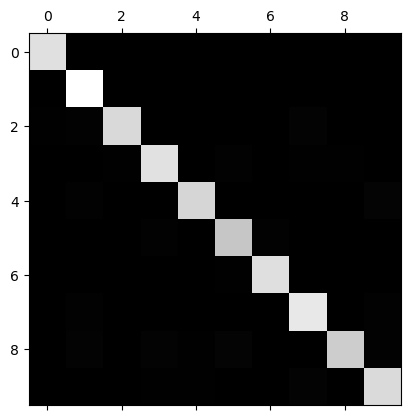

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

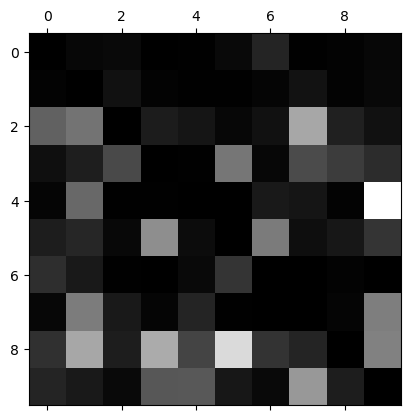

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Part - 4

#### (1)

In [55]:
num_datasets = 100
dataset_size = 50

datasets = np.random.normal(loc=67, scale=3.8, size=(num_datasets, dataset_size))

#### (2)

In [56]:
sample_mean = np.mean(datasets, axis=1)
sample_std = np.std(datasets, axis=1, ddof=1)

#### (3)

In [57]:
import math
uppr_bound = sample_mean + 1.96*(3.8/math.sqrt(dataset_size))
lower_bound = sample_mean - 1.96*(3.8/math.sqrt(dataset_size))

In [58]:
conf_95 = np.zeros((100, 2))

In [59]:
for i in range(100):
    conf_95[i, 0] = lower_bound[i]
    conf_95[i, 1] = uppr_bound[i]

In [60]:
conf_95[:5]

array([[66.36693306, 68.47354559],
       [66.55449753, 68.66111005],
       [66.1202035 , 68.22681602],
       [66.49567884, 68.60229136],
       [65.66186732, 67.76847985]])

#### (4)

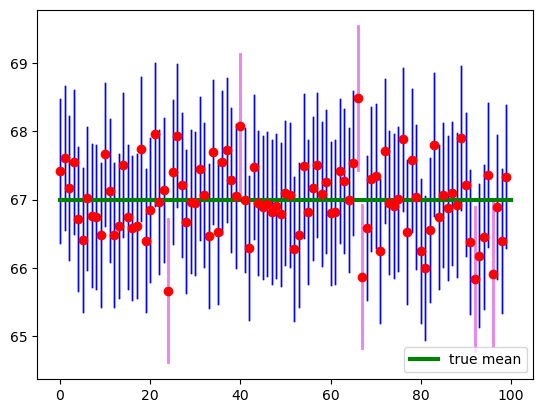

In [61]:
ct = 0
for i in range(num_datasets):
    plt.plot([i, i], conf_95[i], color='blue', linewidth=1)
    plt.scatter(i, sample_mean[i], color='red', zorder=5)
    if (conf_95[i, 0] > 67 or conf_95[i, 1] < 67) :
        plt.plot([i, i], conf_95[i], color='violet', linewidth=2)
        ct += 1
    else:
        plt.plot([i, i], conf_95[i], color='blue', linewidth=1)

plt.plot([0, 100], [67, 67], color="green", label="true mean", linewidth="3")
plt.legend(loc="lower right")
plt.show()

In [62]:
print("No of datasets that have true mean outside their confidence interval: ", ct)

No of datasets that have true mean outside their confidence interval:  6


#### (5)

In [63]:
def findPercent(num_datasets, dataset_size):
    datasets_new = np.random.normal(loc=67, scale=3.8, size=(num_datasets, dataset_size))
    
    sample_mean_new = np.mean(datasets_new, axis=1)
    sample_std_new = np.std(datasets_new, axis=1, ddof=1)
    
    conf_95_new = np.zeros((10000, 2))
    ct = 0
    for i in range(10000):
        conf_95_new[i, 0] = sample_mean_new[i] - 1.96*(3.8/math.sqrt(dataset_size))
        conf_95_new[i, 1] = sample_mean_new[i] + 1.96*(3.8/math.sqrt(dataset_size))
        if (conf_95_new[i, 0] > 67 or conf_95_new[i, 1] < 67) :
            ct += 1
    return ct/10000

for i in range(10):
    print(findPercent(10000, 50))

0.0522
0.0511
0.0479
0.05
0.0514
0.0498
0.0515
0.05
0.0501
0.048


#### (6)

In [64]:
for i in range(10):
    print(findPercent(100000, 50))

0.0498
0.0523
0.048
0.0487
0.0484
0.0532
0.0484
0.0515
0.0505
0.0513


#### (7)

In [65]:
def findPercent(num_datasets, dataset_size):
    datasets_new = np.random.normal(loc=67, scale=3.8, size=(num_datasets, dataset_size))
    
    sample_mean_new = np.mean(datasets_new, axis=1)
    sample_std_new = np.std(datasets_new, axis=1, ddof=1)
    
    conf_95_new = np.zeros((10000, 2))
    ct = 0
    for i in range(10000):
        conf_95_new[i, 0] = sample_mean_new[i] - 1.96*(sample_std_new[i]/math.sqrt(dataset_size))
        conf_95_new[i, 1] = sample_mean_new[i] + 1.96*(sample_std_new[i]/math.sqrt(dataset_size))
        if (conf_95_new[i, 0] > 67 or conf_95_new[i, 1] < 67) :
            ct += 1
    return ct/10000

In [66]:
for i in range(10):
    print(findPercent(100000, 10))

0.0839
0.0785
0.0804
0.0823
0.0828
0.0794
0.0774
0.0806
0.0792
0.0816


#### (8)

In [67]:
def findPercent(num_datasets, dataset_size):
    datasets_new = np.random.normal(loc=67, scale=3.8, size=(num_datasets, dataset_size))
    
    sample_mean_new = np.mean(datasets_new, axis=1)
    sample_std_new = np.std(datasets_new, axis=1, ddof=1)
    
    conf_95_new = np.zeros((10000, 2))
    ct = 0
    for i in range(10000):
        conf_95_new[i, 0] = sample_mean_new[i] - 2.262*(sample_std_new[i]/math.sqrt(dataset_size))
        conf_95_new[i, 1] = sample_mean_new[i] + 2.262*(sample_std_new[i]/math.sqrt(dataset_size))
        if (conf_95_new[i, 0] > 67 or conf_95_new[i, 1] < 67) :
            ct += 1
    return ct/10000

In [68]:
for i in range(10):
    print(findPercent(100000, 10))

0.0478
0.049
0.0466
0.0502
0.0493
0.0501
0.0525
0.0507
0.0494
0.0513
